<a href="https://colab.research.google.com/github/Tarun-Sai99/Breast-Cancer-Classification/blob/main/F1_DS%26ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile, os
zip_path = "/content/F1 WDC.zip"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/f1_wdc")
print("Files:")
for root, dirs, files in os.walk("/content/f1_wdc"):
    for f in files:
        print(os.path.join(root, f))

Files:
/content/f1_wdc/status.csv
/content/f1_wdc/constructor_standings.csv
/content/f1_wdc/lap_times.csv
/content/f1_wdc/races.csv
/content/f1_wdc/qualifying.csv
/content/f1_wdc/constructors.csv
/content/f1_wdc/pit_stops.csv
/content/f1_wdc/results.csv
/content/f1_wdc/driver_standings.csv
/content/f1_wdc/seasons.csv
/content/f1_wdc/drivers.csv
/content/f1_wdc/sprint_results.csv
/content/f1_wdc/constructor_results.csv
/content/f1_wdc/circuits.csv


In [2]:
import pandas as pd
base_path = "/content/f1_wdc"
results = pd.read_csv(f"{base_path}/results.csv")
races = pd.read_csv(f"{base_path}/races.csv")
drivers = pd.read_csv(f"{base_path}/drivers.csv")
constructors = pd.read_csv(f"{base_path}/constructors.csv")
driver_standings = pd.read_csv(f"{base_path}/driver_standings.csv")
constructor_standings = pd.read_csv(f"{base_path}/constructor_standings.csv")
for name, df in {
    "results": results,
    "races": races,
    "drivers": drivers,
    "constructors": constructors,
}.items():
    print(f"\n{name} shape:", df.shape)
    print(df.head(3))


results shape: (26759, 18)
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3       1:27.739         217.586         1  
2         41    5       1:28.090         216.719         1  

races shape: (1125, 18)
   raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix 

In [3]:
df = results.copy()
df["finishes_in_points"] = (df["points"] > 0).astype(int)
df[["raceId", "driverId", "constructorId", "grid", "position", "points", "finishes_in_points"]].head(10)

,raceId,driverId,constructorId,grid,position,points,finishes_in_points
0,18,1,1,1,1,10.0,1
1,18,2,2,5,2,8.0,1
2,18,3,3,7,3,6.0,1
3,18,4,4,11,4,5.0,1
4,18,5,1,3,5,4.0,1
5,18,6,3,13,6,3.0,1
6,18,7,5,17,7,2.0,1
7,18,8,6,15,8,1.0,1
8,18,9,2,2,\N,0.0,0
9,18,10,7,18,\N,0.0,0


In [4]:
# Merge race
df = df.merge(
    races[["raceId", "year", "round", "circuitId", "name"]],
    on="raceId",
    how="left"
)
# Merge driver
df = df.merge(
    drivers[["driverId", "code", "forename", "surname", "nationality"]],
    on="driverId",
    how="left"
)
# Merge constructor
df = df.merge(
    constructors[["constructorId", "name", "nationality"]]
        .rename(columns={"name": "constructor_name",
                         "nationality": "constructor_nationality"}),
    on="constructorId",
    how="left"
)
df.head(5)
df.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'finishes_in_points', 'year', 'round',
       'circuitId', 'name', 'code', 'forename', 'surname', 'nationality',
       'constructor_name', 'constructor_nationality'],
      dtype='object')

In [5]:
use_cols = [
    "year",
    "round",
    "grid",
    "positionOrder",
    "points",
    "circuitId",
    "driverId",
    "constructorId",
    "finishes_in_points"
]
model_df = df[use_cols].copy()
model_df = model_df.dropna(subset=["grid", "positionOrder", "points"])
print(model_df.shape)
model_df.head()

(26759, 9)


,year,round,grid,positionOrder,points,circuitId,driverId,constructorId,finishes_in_points
0,2008,1,1,1,10.0,1,1,1,1
1,2008,1,5,2,8.0,1,2,2,1
2,2008,1,7,3,6.0,1,3,3,1
3,2008,1,11,4,5.0,1,4,4,1
4,2008,1,3,5,4.0,1,5,1,1


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
X = model_df.drop(columns=["finishes_in_points"])
y = model_df["finishes_in_points"]
numeric_cols = ["year", "round", "grid", "positionOrder", "points"]
cat_cols = ["circuitId", "driverId", "constructorId"]
X_num = X[numeric_cols].copy()
X_cat = X[cat_cols].copy()
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_cat_encoded = enc.fit_transform(X_cat)
import numpy as np
X_all = np.hstack([X_num.values, X_cat_encoded])
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3718
           1       1.00      1.00      1.00      1634

    accuracy                           1.00      5352
   macro avg       1.00      1.00      1.00      5352
weighted avg       1.00      1.00      1.00      5352



In [7]:
use_cols = [
    "year",
    "round",
    "grid",
    "circuitId",
    "driverId",
    "constructorId",
    "finishes_in_points"
]
model_df = df[use_cols].copy()
model_df = model_df.dropna(subset=["grid"])
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
X = model_df.drop(columns=["finishes_in_points"])
y = model_df["finishes_in_points"]
numeric_cols = ["year", "round", "grid"]
cat_cols = ["circuitId", "driverId", "constructorId"]
X_num = X[numeric_cols].copy()
X_cat = X[cat_cols].copy()
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_cat_encoded = enc.fit_transform(X_cat)
X_all = np.hstack([X_num.values, X_cat_encoded])
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3718
           1       0.65      0.55      0.60      1634

    accuracy                           0.77      5352
   macro avg       0.73      0.71      0.72      5352
weighted avg       0.77      0.77      0.77      5352



In [11]:
driver_standings_with_year = driver_standings.merge(races[['raceId', 'year']], on='raceId', how='left')
driver_standings_with_year.head(),
driver_standings_with_year.columns,
driver_standings_with_year.year.unique()[:10],
constructor_standings.head(),
constructor_standings.columns

Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins'],
      dtype='object')

In [12]:
driver_standings_with_year = driver_standings.merge(
    races[["raceId", "year"]],
    on="raceId",
    how="left"
)
print(driver_standings_with_year.head())
print(driver_standings_with_year.columns)
print(driver_standings_with_year["year"].unique()[:10])

   driverStandingsId  raceId  driverId  points  position positionText  wins  \
0                  1      18         1    10.0         1            1     1   
1                  2      18         2     8.0         2            2     0   
2                  3      18         3     6.0         3            3     0   
3                  4      18         4     5.0         4            4     0   
4                  5      18         5     4.0         5            5     0   

   year  
0  2008  
1  2008  
2  2008  
3  2008  
4  2008  
Index(['driverStandingsId', 'raceId', 'driverId', 'points', 'position',
       'positionText', 'wins', 'year'],
      dtype='object')
[2008 2007 2006 2005 2004 2003 2002 2001 2000 1999]


In [13]:
driver_strength = (
    driver_standings_with_year
    .groupby(["year", "driverId"], as_index=False)
    .agg(
        season_points=("points", "max"),
        season_wins=("wins", "max"),
        best_position=("position", "min"),
        races_count=("raceId", "nunique")
    )
)

driver_strength = driver_strength.merge(
    drivers[["driverId", "code", "forename", "surname", "nationality"]],
    on="driverId",
    how="left"
)
driver_strength["raw_score"] = (
    driver_strength["season_points"]
    + 5 * driver_strength["season_wins"]
    + (30 - driver_strength["best_position"].clip(upper=30))
)
driver_strength["strength_score"] = (
    driver_strength.groupby("year")["raw_score"]
    .transform(lambda x: x / x.max())
)
driver_strength.sort_values(["year", "strength_score"], ascending=[True, False]).head(10)

,year,driverId,season_points,season_wins,best_position,races_count,code,forename,surname,nationality,raw_score,strength_score
23,1950,642,30.0,3,1,7,\N,Nino,Farina,Italian,74.0,1.000000
11,1950,579,27.0,3,1,7,\N,Juan,Fangio,Argentine,71.0,0.959459
63,1950,786,24.0,0,2,7,\N,Luigi,Fagioli,Italian,52.0,0.702703
13,1950,593,9.0,1,3,5,\N,Johnnie,Parsons,American,41.0,0.554054
18,1950,627,13.0,0,4,7,\N,Louis,Rosier,French,39.0,0.527027
24,1950,647,11.0,0,4,6,\N,Alberto,Ascari,Italian,37.0,0.500000
34,1950,686,4.0,0,3,7,\N,Reg,Parnell,British,31.0,0.418919
37,1950,701,6.0,0,6,5,\N,Bill,Holland,American,30.0,0.405405
12,1950,589,4.0,0,5,7,\N,Louis,Chiron,Monegasque,29.0,0.391892
38,1950,704,3.0,0,4,7,\N,Yves,Cabantous,French,29.0,0.391892


In [14]:
constructor_standings_with_year = constructor_standings.merge(
    races[["raceId", "year"]],
    on="raceId",
    how="left"
)
constructor_strength = (
    constructor_standings_with_year
    .groupby(["year", "constructorId"], as_index=False)
    .agg(
        season_points=("points", "max"),
        season_wins=("wins", "max"),
        best_position=("position", "min"),
        races_count=("raceId", "nunique")
    )
)
constructor_strength = constructor_strength.merge(
    constructors[["constructorId", "name", "nationality"]],
    on="constructorId",
    how="left"
)
constructor_strength["raw_score"] = (
    constructor_strength["season_points"]
    + 5 * constructor_strength["season_wins"]
    + (30 - constructor_strength["best_position"].clip(upper=30))
)
constructor_strength["strength_score"] = (
    constructor_strength.groupby("year")["raw_score"]
    .transform(lambda x: x / x.max())
)
constructor_strength.sort_values(["year", "strength_score"], ascending=[True, False]).head(10)


,year,constructorId,season_points,season_wins,best_position,races_count,name,nationality,raw_score,strength_score
6,1958,118,48.0,6,1,10,Vanwall,British,107.0,1.000000
0,1958,6,40.0,2,1,11,Ferrari,Italian,79.0,0.738318
3,1958,87,31.0,2,1,11,Cooper,British,70.0,0.654206
2,1958,66,18.0,0,4,10,BRM,British,44.0,0.411215
5,1958,105,6.0,0,3,11,Maserati,Italian,33.0,0.308411
1,1958,32,3.0,0,5,10,Team Lotus,British,28.0,0.261682
4,1958,95,0.0,0,7,9,Porsche,German,23.0,0.214953
7,1958,125,0.0,0,7,10,Connaught,British,23.0,0.214953
8,1958,127,0.0,0,8,10,OSCA,Italian,22.0,0.205607
24,1959,170,40.0,5,1,9,Cooper-Climax,British,94.0,1.000000


In [15]:
def top_drivers_year(year, n=10):
    return (
        driver_strength[driver_strength["year"] == year]
        .sort_values("strength_score", ascending=False)
        .head(n)[
            ["year", "code", "forename", "surname",
             "season_points", "season_wins", "best_position", "strength_score"]
        ]
    )
def top_constructors_year(year, n=10):
    return (
        constructor_strength[constructor_strength["year"] == year]
        .sort_values("strength_score", ascending=False)
        .head(n)[
            ["year", "name", "season_points", "season_wins",
             "best_position", "strength_score"]
        ]
    )
print(top_drivers_year(2019).head())
print(top_constructors_year(2019).head())

      year code   forename     surname  season_points  season_wins  \
3060  2019  HAM      Lewis    Hamilton          413.0           11   
3068  2019  BOT   Valtteri      Bottas          326.0            4   
3071  2019  VER        Max  Verstappen          278.0            3   
3076  2019  LEC    Charles     Leclerc          264.0            2   
3063  2019  VET  Sebastian      Vettel          240.0            1   

      best_position  strength_score  
3060              1        1.000000  
3068              1        0.754527  
3071              3        0.643863  
3076              3        0.605634  
3063              3        0.547284  
     year      name  season_points  season_wins  best_position  strength_score
867  2019  Mercedes          739.0           15              1        1.000000
864  2019   Ferrari          504.0            3              2        0.648873
865  2019  Red Bull          417.0            3              3        0.544484
860  2019   McLaren          145.0 

In [17]:
era_start, era_end = 2020, 2025

era_driver_strength = driver_strength.query("year >= @era_start and year <= @era_end")
era_constructor_strength = constructor_strength.query("year >= @era_start and year <= @era_end")
era_top3_drivers = (
    era_driver_strength
    .sort_values(["year", "strength_score"], ascending=[True, False])
    .groupby("year")
    .head(3)
    .reset_index(drop=True)
)
era_top3_constructors = (
    era_constructor_strength
    .sort_values(["year", "strength_score"], ascending=[True, False])
    .groupby("year")
    .head(3)
    .reset_index(drop=True)
)
print("Top 3 drivers per season (2020–2025):")
display(era_top3_drivers[[
    "year", "code", "forename", "surname",
    "season_points", "season_wins", "best_position", "strength_score"
]])
print("Top 3 constructors per season (2020–2025):")
display(era_top3_constructors[[
    "year", "name",
    "season_points", "season_wins", "best_position", "strength_score"
]])


Top 3 drivers per season (2020–2025):


,year,code,forename,surname,season_points,season_wins,best_position,strength_score
0,2020,HAM,Lewis,Hamilton,347.0,11,1,1.000000
1,2020,BOT,Valtteri,Bottas,223.0,2,1,0.607889
2,2020,VER,Max,Verstappen,214.0,2,2,0.584687
3,2021,VER,Max,Verstappen,395.5,10,1,1.000000
4,2021,HAM,Lewis,Hamilton,387.5,8,1,0.962065
5,2021,BOT,Valtteri,Bottas,226.0,1,3,0.543730
6,2022,VER,Max,Verstappen,454.0,15,1,1.000000
7,2022,LEC,Charles,Leclerc,308.0,3,1,0.630824
8,2022,PER,Sergio,Pérez,305.0,2,2,0.614695
9,2023,VER,Max,Verstappen,575.0,19,1,1.000000


Top 3 constructors per season (2020–2025):


,year,name,season_points,season_wins,best_position,strength_score
0,2020,Mercedes,573.0,13,1,1.000000
1,2020,Red Bull,319.0,2,2,0.535232
2,2020,McLaren,202.0,0,2,0.344828
3,2021,Mercedes,613.5,9,1,1.000000
4,2021,Red Bull,585.5,11,1,0.973818
5,2021,Ferrari,323.5,0,3,0.509818
6,2022,Red Bull,759.0,17,1,1.000000
7,2022,Ferrari,554.0,4,1,0.690722
8,2022,Mercedes,515.0,1,2,0.627721
9,2023,Red Bull,860.0,21,1,1.000000


In [18]:
driver_gaps = (
    era_top3_drivers
    .sort_values(["year", "strength_score"], ascending=[True, False])
    .groupby("year")
    .apply(
        lambda g: pd.Series({
            "champ": f"{g.iloc[0]['code']} ({g.iloc[0]['season_points']})",
            "runner_up": f"{g.iloc[1]['code']} ({g.iloc[1]['season_points']})" if len(g) > 1 else None,
            "points_gap": g.iloc[0]["season_points"] - (g.iloc[1]["season_points"] if len(g) > 1 else 0),
            "strength_gap": g.iloc[0]["strength_score"] - (g.iloc[1]["strength_score"] if len(g) > 1 else 0),
        })
    )
    .reset_index()
)
driver_gaps

/tmp/ipython-input-806217841.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,year,champ,runner_up,points_gap,strength_gap
0,2020,HAM (347.0),BOT (223.0),124.0,0.392111
1,2021,VER (395.5),HAM (387.5),8.0,0.037935
2,2022,VER (454.0),LEC (308.0),146.0,0.369176
3,2023,VER (575.0),PER (285.0),290.0,0.537911
4,2024,VER (437.0),NOR (374.0),63.0,0.174168


In [19]:
constructor_gaps = (
    era_top3_constructors
    .sort_values(["year", "strength_score"], ascending=[True, False])
    .groupby("year")
    .apply(
        lambda g: pd.Series({
            "champ_team": f"{g.iloc[0]['name']} ({g.iloc[0]['season_points']})",
            "runner_up_team": f"{g.iloc[1]['name']} ({g.iloc[1]['season_points']})" if len(g) > 1 else None,
            "points_gap": g.iloc[0]["season_points"] - (g.iloc[1]["season_points"] if len(g) > 1 else 0),
            "strength_gap": g.iloc[0]["strength_score"] - (g.iloc[1]["strength_score"] if len(g) > 1 else 0),
        })
    )
    .reset_index()
)
constructor_gaps

/tmp/ipython-input-2172646955.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,year,champ_team,runner_up_team,points_gap,strength_gap
0,2020,Mercedes (573.0),Red Bull (319.0),254.0,0.464768
1,2021,Mercedes (613.5),Red Bull (585.5),28.0,0.026182
2,2022,Red Bull (759.0),Ferrari (554.0),205.0,0.309278
3,2023,Red Bull (860.0),Ferrari (406.0),454.0,0.559356
4,2024,McLaren (666.0),Ferrari (652.0),14.0,0.027586


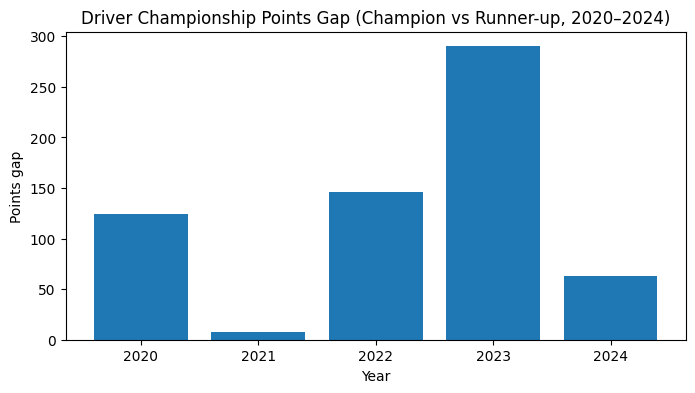

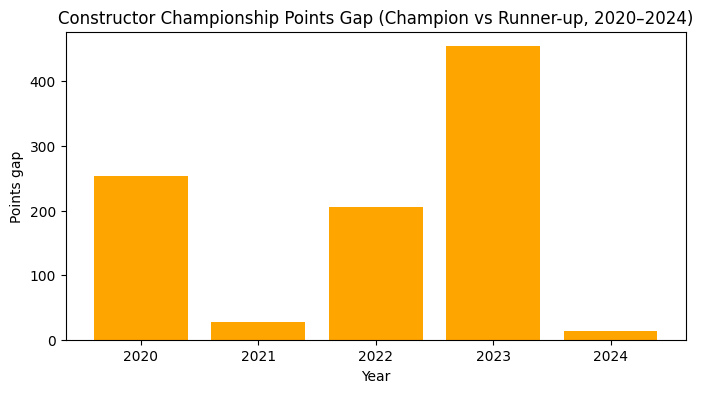

In [20]:
import matplotlib.pyplot as plt
# Driver points gap bar chart
plt.figure(figsize=(8,4))
plt.bar(driver_gaps["year"], driver_gaps["points_gap"])
plt.title("Driver Championship Points Gap (Champion vs Runner-up, 2020–2024)")
plt.xlabel("Year")
plt.ylabel("Points gap")
plt.show()

# Constructor points gap bar chart
plt.figure(figsize=(8,4))
plt.bar(constructor_gaps["year"], constructor_gaps["points_gap"], color="orange")
plt.title("Constructor Championship Points Gap (Champion vs Runner-up, 2020–2024)")
plt.xlabel("Year")
plt.ylabel("Points gap")
plt.show()

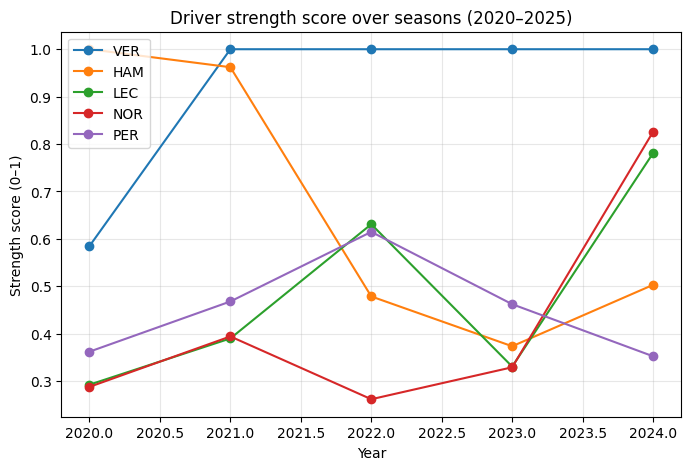

In [21]:
import matplotlib.pyplot as plt
key_driver_codes = ["VER", "HAM", "LEC", "NOR", "PER"]
plot_drivers = (
    driver_strength[
        (driver_strength["year"].between(2020, 2025))
        & (driver_strength["code"].isin(key_driver_codes))
    ][["year", "code", "strength_score"]]
)
plt.figure(figsize=(8,5))
for code in key_driver_codes:
    sub = plot_drivers[plot_drivers["code"] == code]
    if not sub.empty:
        plt.plot(sub["year"], sub["strength_score"], marker="o", label=code)
plt.title("Driver strength score over seasons (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Strength score (0–1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


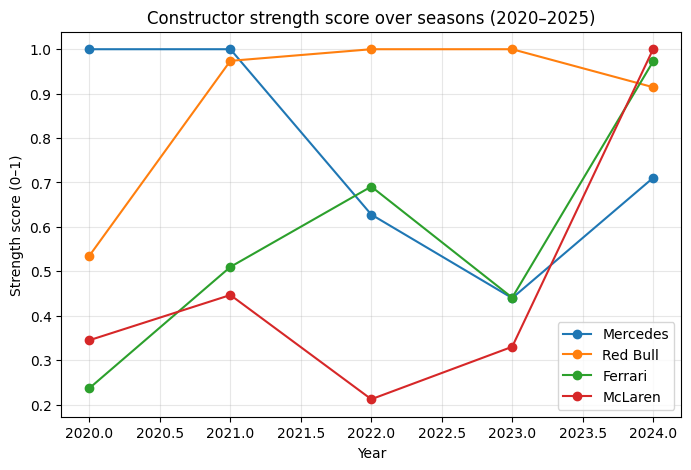

In [22]:
key_teams = ["Mercedes", "Red Bull", "Ferrari", "McLaren"]
plot_teams = (
    constructor_strength[
        (constructor_strength["year"].between(2020, 2025))
        & (constructor_strength["name"].isin(key_teams))
    ][["year", "name", "strength_score"]]
)
plt.figure(figsize=(8,5))
for name in key_teams:
    sub = plot_teams[plot_teams["name"] == name]
    if not sub.empty:
        plt.plot(sub["year"], sub["strength_score"], marker="o", label=name)
plt.title("Constructor strength score over seasons (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Strength score (0–1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


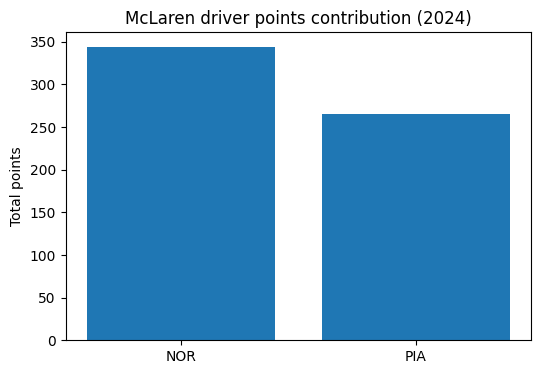

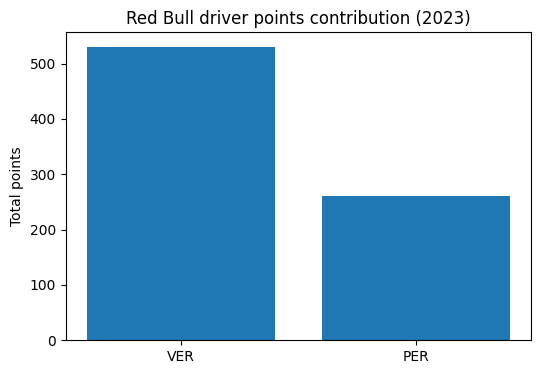

In [26]:
def plot_team_driver_points(year, constructor_name, top_n=2):
    # all driver-season rows joined with constructors via results
    merged = (
        results.merge(races[["raceId", "year"]], on="raceId", how="left")
        .merge(constructors[["constructorId", "name"]], on="constructorId", how="left")
        .merge(drivers[["driverId", "code", "forename", "surname"]], on="driverId", how="left")
    )
    team_year = merged[(merged["year"] == year) & (merged["name"] == constructor_name)]

    driver_points = (
        team_year.groupby(["driverId", "code", "forename", "surname"], as_index=False)["points"]
        .sum()
        .sort_values("points", ascending=False)
        .head(top_n)
    )
    plt.figure(figsize=(6,4))
    labels = driver_points["code"].fillna(driver_points["surname"])
    plt.bar(labels, driver_points["points"])
    plt.title(f"{constructor_name} driver points contribution ({year})")
    plt.ylabel("Total points")
    plt.show()
# Examples:
plot_team_driver_points(2024, "McLaren")
plot_team_driver_points(2023, "Red Bull")


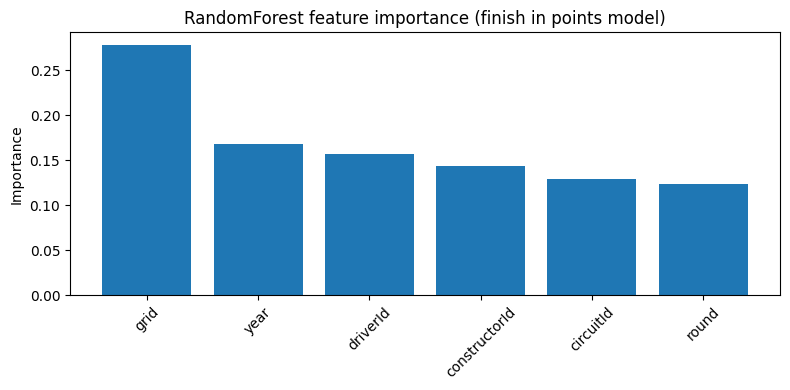

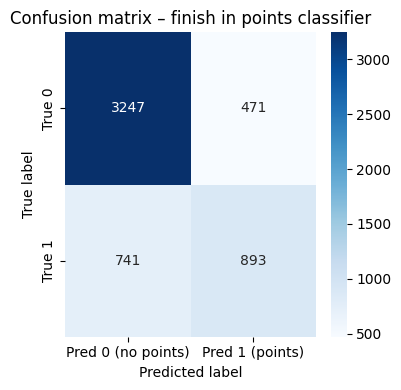

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

feature_names = numeric_cols + cat_cols

# Feature importance bar chart
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.bar(range(len(feature_names)), importances[indices])
plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=45)
plt.ylabel("Importance")
plt.title("RandomForest feature importance (finish in points model)")
plt.tight_layout()
plt.show()

# Confusion matrix heatmap
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0 (no points)", "Pred 1 (points)"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion matrix – finish in points classifier")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

In [25]:
driver_strength.to_csv("driver_strength.csv", index=False)
constructor_strength.to_csv("constructor_strength.csv", index=False)
driver_gaps.to_csv("driver_title_gaps_2020_2024.csv", index=False)
constructor_gaps.to_csv("constructor_title_gaps_2020_2024.csv", index=False)